<font size=4>
In the last notebook we made a neural network using Pytorch's nn.Module class. Here we'll discuss how to use torch Datasets, which allow one to efficiently do things like batch data, apply data augmentations, etc.
</font>

In [2]:
# for neural networks etc.
import torch.nn as nn
import torch

# for the dataset
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# for the data generation
import numpy as np
import scipy.integrate

# for plotting
import matplotlib.pyplot as plt 
from matplotlib import animation
from IPython.display import HTML

<font size=4>
For this notebook, we're going to do something slightly more interesting than previously. We will take data from a Lorenz attractor (a standard chaotic dynamical system) and see if we can compress it into a two dimensional representation that still allows us to predict the dynamics.
</font>

In [7]:
n_init_cond = 100

# Make initial conditions
init_x = 40*np.random.uniform(0, high=1,size=(n_init_cond,3)) 
init_x[:,0] -= 20
init_x[:,1] -= 20

# Parameter values
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

# Equations of motion. \dot x = lorenz(x)
def lorenz(t, state):
    x, y, z = state
     
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
     
    return [xdot, ydot, zdot]


teval = np.linspace(0, 100, 5001) # times to sample at

trajectories = []
for init in init_x:
    trajectories.append( scipy.integrate.solve_ivp(lorenz, [0, teval[-1]], init, t_eval=teval).y )

trajectories = np.asarray(trajectories) # shape: [N init cond, 3, Time]

In [5]:
print(trajectories.shape) # 

(500, 3, 1001)


Text(0, 0.5, 'z')

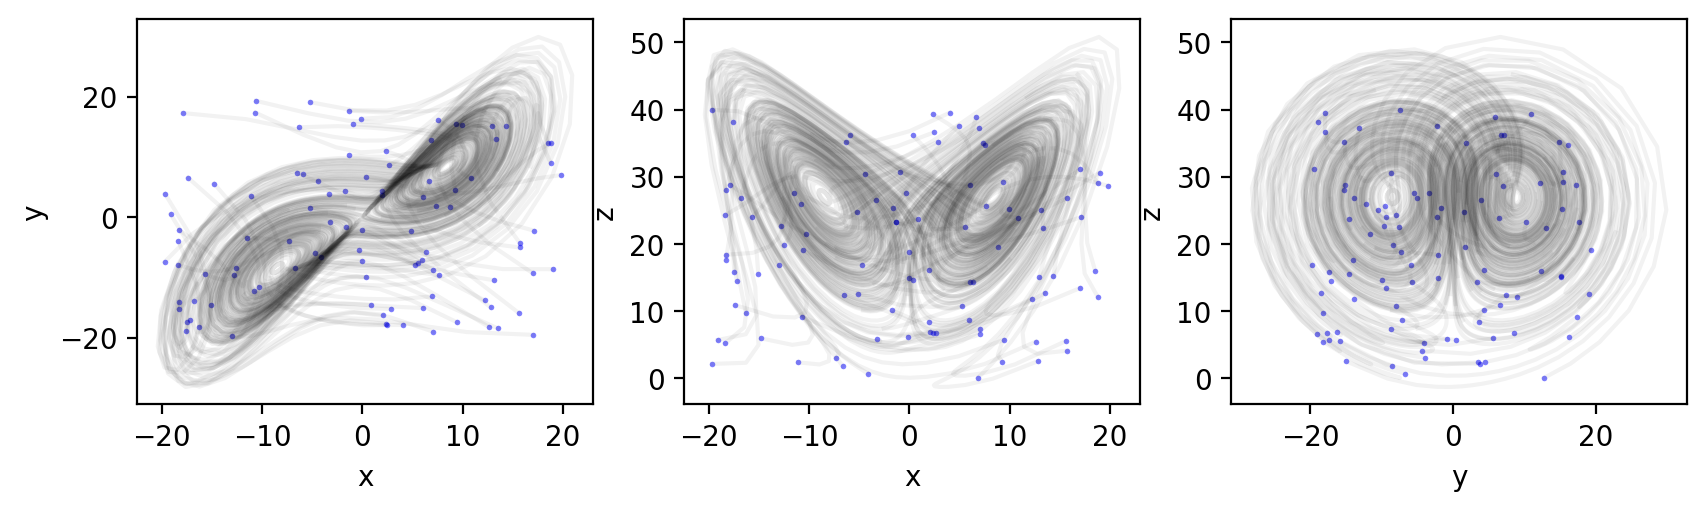

In [9]:
fig,ax=plt.subplots(1,3,figsize=(10,2.5),dpi=200)

T_stop = 100
for traj in trajectories:
    # plot init conditions in blue
    ax[0].scatter(traj[0, 0], traj[1, 0], color='b', s=4, alpha=0.5, lw=0)
    ax[1].scatter(traj[0, 0], traj[2, 0], color='b', s=4, alpha=0.5, lw=0)
    ax[2].scatter(traj[1, 0], traj[2, 0], color='b', s=4, alpha=0.5, lw=0)

    # plot trajectories
    ax[0].plot(traj[0, :T_stop], traj[1, :T_stop], color='k', alpha=0.05)
    ax[1].plot(traj[0, :T_stop], traj[2, :T_stop], color='k', alpha=0.05)
    ax[2].plot(traj[1, :T_stop], traj[2, :T_stop], color='k', alpha=0.05)

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

ax[2].set_xlabel('y')
ax[2].set_ylabel('z')

# The Dataset Class

<font size=4>
Datasets in pytorch have two essential methods: __init__ and __getitem__.

\_\_init__ typically will load in your data (if it can all be loaded into memory at the same time) and push it onto gpu if possible.

\_\_getitem__ will specify how to draw samples from your dataset. For supervised tasks, these will be input-output pairs. This is important, since the automated batching in pytorch works by generating random sets of indices. The getitem class tells us how an index should be mapped to a sample.

</font>


<font size=4>
First we'll start with a mini dataset class that just makes pairs of random vectors:
</font>

In [30]:
class DatasetMini(Dataset):
    def __init__(self, input_size=10, output_size=15, n_samples=150):
        x_data = np.random.randn(n_samples, input_size)
        y_data = np.random.randn(n_samples, output_size)

        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).float()

    def __len__(self): # len should always return the total number of data samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        return {'input': self.x[idx], 
                'output': self.y[idx]}
    

In [31]:
# get a sample:
dataset = DatasetMini(input_size=3, output_size=6, n_samples=12)

print("Dataset x data:", dataset.x)
print("Dataset y data:", dataset.y)

# Draw a single sample:
sample = dataset[0] # contains an input output pair
print("One sample:", sample)

# Datasets are iterable! 
for i, sample in enumerate(dataset): # it is important to define the __len__ function so the iteration knows when to stop
    print(f"Sample {i}", sample)

Dataset x data: tensor([[-0.3943, -0.3720,  0.3648],
        [ 0.3654,  0.2255,  0.4142],
        [ 0.8116,  0.0708,  1.3188],
        [-0.7577,  0.2493, -0.0552],
        [-0.1379, -1.4983, -0.6364],
        [ 0.9051,  0.4111, -0.4853],
        [ 0.3296,  0.2370, -0.0034],
        [ 1.1145, -0.6847,  0.2971],
        [ 0.8342,  1.8673, -0.6308],
        [ 0.1585, -1.2802, -0.0191],
        [ 1.7750, -0.2532, -0.2598],
        [ 2.3550,  0.0163, -1.1443]])
Dataset y data: tensor([[ 0.3205,  1.0234,  1.4613, -0.7581,  0.0110,  0.9725],
        [ 1.8214, -0.1681, -0.2825, -0.2584,  0.0515, -1.2888],
        [ 0.1790, -0.4226, -0.3721,  1.7094,  0.6249,  0.4780],
        [-0.5751, -0.0319,  0.6823,  0.5707, -1.2789,  1.1237],
        [-1.3932,  0.3423,  0.0184, -0.0199,  0.8223,  1.2626],
        [-0.2034, -0.9556,  3.1515,  0.9151,  0.4002,  0.2868],
        [ 0.4639, -0.6768, -1.8688,  0.3119,  0.1535,  1.0279],
        [ 0.2827,  1.0193,  0.4211, -1.4508,  0.3123,  0.1880],
        [ 1

# Data loaders:
<font size=4>
Above, we draw each sample individually. In pytorch, we can efficiently sample an entire batch of data by using a dataloader. In the case that we have to move data from cpu to gpu at every step, this also takes care of gpu memory allocation (via the "pin_memory" argument).

</font>

In [33]:
class DatasetMini_with_Index(Dataset):
    def __init__(self, input_size=10, output_size=15, n_samples=150):
        x_data = np.random.randn(n_samples, input_size)
        y_data = np.random.randn(n_samples, output_size)

        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).float()

    def __len__(self): # len should always return the total number of data samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        return {'input': self.x[idx], 
                'output': self.y[idx],
                'idx': idx} ## <------------------------------- keep track of the indices for now, just so we can see what loader is doing
        

In [40]:
dataset = DatasetMini_with_Index()

indices = np.arange(len(dataset))
sampler = SubsetRandomSampler(indices) # this will generate random samples from our indices
loader = torch.utils.data.DataLoader(dataset, batch_size=24, num_workers=0, sampler=sampler, pin_memory=False)

batch = next(x for x in loader) # loader is an iterable, but we cannot index it! This is how we can get the first sample.

print("Each batch has same keys as an individual sample:", sample.keys())
print("Each key in the dict will be stacked, so it is now size [Batchsize, Input dim]:", sample['input'].shape)

Each batch has same keys as an individual sample: dict_keys(['input', 'output', 'idx'])
Each key in the dict will be stacked, so it is now size [Batchsize, Input dim]: torch.Size([20, 10])


# Dataloader for the Lorenz dynamics data

<font size=4>
Now we'll put it all together for our real dataset. Note that I typically make the loader into an attribute of the dataset itself, as you can see below.

</font>

In [41]:
print(trajectories.shape)

(100, 3, 5001)


In [44]:
class DatasetLorenz(Dataset):
    def __init__(self, 
                 trajectory_data, # our trajectory data. Shape: [n init cond, 3, T]
                 dT=10, # the time horizon over which we'd like to make predictions
                 batch_size=128
                ):
        
        self.data = trajectory_data # Shape: [n init cond, 3, T]
        self.data = self.data.transpose(0,2,1) # Shape: [n init cond, T, 3]
        self.data = torch.from_numpy(self.data)
        self.dT = dT

        self.loader = self.make_loader(indices=np.arange(len(self)), batch_size=batch_size, num_workers=0, pin_memory=False)
        

    def __len__(self): # len should always return the total number of data samples
        return self.data.shape[0] * (self.data.shape[1] - self.dT) # for each initial condition, we can take a sample from 0 to the -dT'th index

    def __getitem__(self, idx):
        idx = np.unravel_index(idx, shape=(self.data.shape[0], self.data.shape[1] - self.dT))

        x0 = self.data[idx[0], idx[1], :]
        xT = self.data[idx[0], idx[1]+self.dT, :]
        
        return {'input': x0, 
                'output': xT,
                'idx': idx}

    def make_loader(self, indices, batch_size, num_workers, pin_memory=True):
            sampler = SubsetRandomSampler(indices)
            loader = torch.utils.data.DataLoader(self, 
                batch_size=batch_size,
                num_workers=num_workers,
                sampler=sampler,
                pin_memory=pin_memory)
            
            self.loader = loader
            return

In [46]:
dataset_lorenz = DatasetLorenz(trajectories)
print(dataset_lorenz.data.shape)

torch.Size([100, 5001, 3])


In [18]:
class NNModel(nn.Module):
    def __init__(self, 
                 input_size=1, # number of channels/dimensions of the input
                 output_size=1, # number of channels/dimensions of the output
                 n_channels=64, # number of channels/dimensions of inner layers
                 n_layers=2, # number of intermediate layers
                 activation_fct=nn.ReLU(),
                 optimization_hyperparameters={'LR': 1e-3}):

        super().__init__() # initialize nn.Module

        ## MAKE THE NETWORK
        self.layers = nn.ModuleList() # this will be a list of all our neural network layers. You can append to it just like to a normal list

        self.layers.append(nn.Linear(input_size, n_channels)) # First layer
        self.layers.append(activation_fct) # Activation on first layer

        for _ in range(n_layers-1):
            self.layers.append(nn.Linear(n_channels, n_channels)) # intermediate layer
            self.layers.append(activation_fct) # activation
        
        self.layers.append(nn.Linear(n_channels, output_size)) # Last layer. Don't activate, unless you want values in [0, infty] 


        ## MAKE THE OPTIMIZER. 
        # This will keep track of things like learning rate, optimization steps, and which parameters we want to apply gradients to.
        # self.parameters will get all the parameters in the layers that we have initialized so far, so make sure to do this step last.
        self.optimizer = torch.optim.Adam(self.parameters(), lr=optimization_hyperparameters['LR'])



    def forward(self, input):
        x = input.clone()

        for layer in self.layers:
            x = layer(x) # apply each layer to the input
            
        return x # this is our prediction


In [42]:
model = NNModel(input_size=1, # number of channels/dimensions of the input
                 output_size=1, # number of channels/dimensions of the output
                 n_channels=64, # number of channels/dimensions of inner layers
                 n_layers=2, # number of intermediate layers
                 activation_fct=nn.ReLU(),
                 optimization_hyperparameters={'LR': 1e-3})

# FOR YOU TO DO!
The network (in the case of `n_layers=2`) is computing a function $f_{NN}=W_3 \phi(W_2 \phi (W_1 x + b_1) + b_2 )$.
What are the shapes of $W_{1-3}$, $b_{1-2}$?


(-2.0, 2.0)

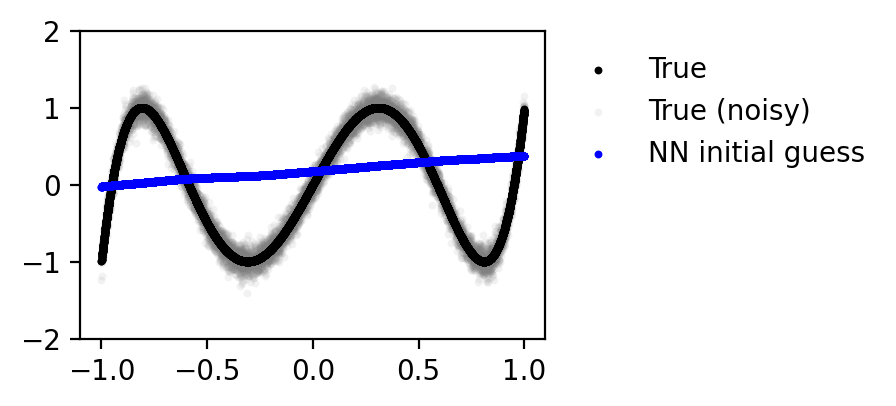

In [43]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)

ax.scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
ax.scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
ax.scatter(inputs, model(inputs).detach(), s=8, color='b', alpha=1, lw=0, label='NN initial guess')

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.set_ylim(-2,2)

# Gradient descent applied to our data

In [45]:
prediction_history = []
loss_history = []

for step in range(1000):
    model.optimizer.zero_grad() # clear any gradients, so that we can calculate them anew

    predictions = model(inputs)

    loss = torch.mean((predictions - outputs)**2) # here I do mean (instead of sum) to keep the values of the loss small. Otherwise they can blow up.
    
    loss.backward() # calculate gradients
    model.optimizer.step() # will do a gradient step

    loss_history.append(loss.detach())
    prediction_history.append(predictions.detach().cpu().numpy())


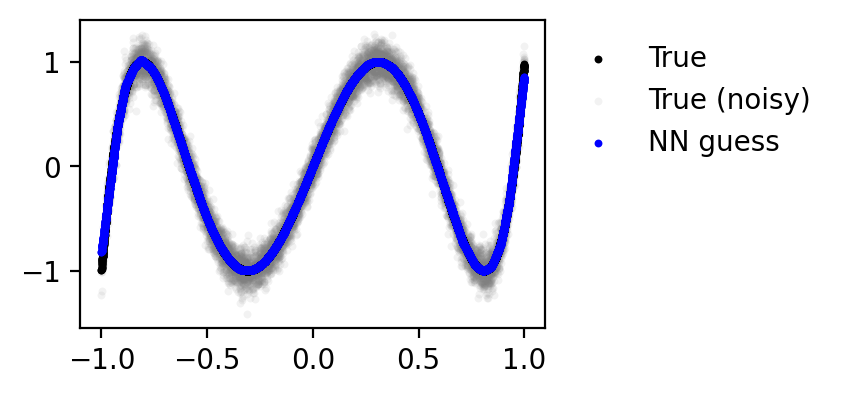

In [39]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)

ax.scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
ax.scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
ax.scatter(inputs, model(inputs).detach().cpu(), s=8, color='b', alpha=1, lw=0, label='NN guess')

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)

In [40]:
def plot_evolving_loss_and_curve(predictions, loss_vals, lineclr = 'k', linealpha=0.99, interval=20):
    def init():
        scat.set_offsets(np.asarray([inputs.squeeze(), predictions[0].squeeze()]).T) # takes Nx2 array
        line.set_data([[0], [loss_vals[0]]])

        return (scat, line)
    
    def animate(i):
        scat.set_offsets(np.asarray([inputs.squeeze(), predictions[i].squeeze()]).T) # takes Nx2 array
        line.set_data([np.arange(i), loss_vals[:i]])

        ax[0].set_title(f'Loss = {loss_vals[i].detach().squeeze():0.2f}')
    
        return (scat, line)

    
    
    fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)
    
    ax[0].scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
    ax[0].scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
    scat = ax[0].scatter(inputs, predictions[0], s=8, color='b', alpha=1, lw=0, label='NN guess')
    
    line, = ax[1].plot([0], [loss_vals[0]], color='r')
    
    ax[1].set_xlim(0, len(loss_vals))
    ax[1].set_ylim(np.min(loss_vals), np.max(loss_vals))
    ax[1].set_yscale('log')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('N Steps')
    
    plt.close();
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(loss_vals), interval=interval, blit=True)
    return anim


In [41]:
HTML(plot_evolving_loss_and_curve(prediction_history[::20], loss_history[::20], interval=20, lineclr='k', linealpha=0.1).to_html5_video())

# THINGS FOR YOU TO TRY!
1) Try putting the model on the gpu!
2) Make a plot of how the final loss (attained after some number of steps that you can decide) depends on:
     - learning rate (do a log-scale sweep, from (for example) 1e-1 to 1e-5)
     - number of channels and/or layers
     - activation function (look up some common ones)

# Some other useful functions for neural networks

<font size=4>
Print them:
</font>

In [46]:
print(model)

NNModel(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


<font size=4>
Look at the parameters (weights/biases)
</font>

In [52]:
# This will show all the parameters, together with their "names"
[[n, p.shape] for n,p in model.named_parameters()]

[['layers.0.weight', torch.Size([64, 1])],
 ['layers.0.bias', torch.Size([64])],
 ['layers.2.weight', torch.Size([64, 64])],
 ['layers.2.bias', torch.Size([64])],
 ['layers.4.weight', torch.Size([1, 64])],
 ['layers.4.bias', torch.Size([1])]]

 <font size=5>
<b>Q: Why do layers 1, 3 not have names?</b>
</font>

<font size=4>
Let's plot some of the weights
</font>

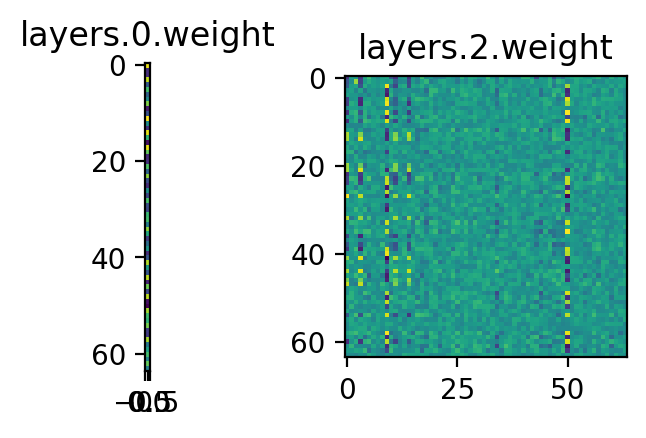

In [61]:
weights_to_plot = ['layers.0.weight', 'layers.2.weight']

named_weight_dict = {n: p for n,p in model.named_parameters()}

fig,ax=plt.subplots(1, len(weights_to_plot), figsize=(len(weights_to_plot)*2, 2), dpi=200)

for a, w in zip(ax, weights_to_plot):
    a.imshow(named_weight_dict[w].detach().cpu().numpy())
    a.set_title(w)